#  Análisis de Componentes Principales (_Principal Component Analysis_, PCA)

Up until now, we have been looking in depth at supervised learning estimators: those estimators that predict labels based on labeled training data.
Here we begin looking at several unsupervised estimators, which can highlight interesting aspects of the data without reference to any known labels.

En esta clase exploraremos una de las técnicas no supervisadas más utilizadas: el análisis de componentes principales, o PCA.
PCA es fundamentalmente una técnica de reducción dimensional, pero también puede ser una herramienta útil para visualización, para filtrado de ruido, para extracción e ingeniería de características, y más.
Después de una discusión breve sobre el método, veremos un par de ejemplos de las aplicaciones mencionadas.

Como siempre, comenzamos con un preámbulo:

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%config InlineBackend.figure_format = 'retina'

## Introducción

PCA es una técnica no supervisada rápida y flexible para reducir la dimensionalidad de los datos, que vimos brevemente en la introducción a Scikit-Learn.
Su comportamiento es fácil de visualizar si observamos un dataset bidimensional como el siguiente, de 200 puntos:

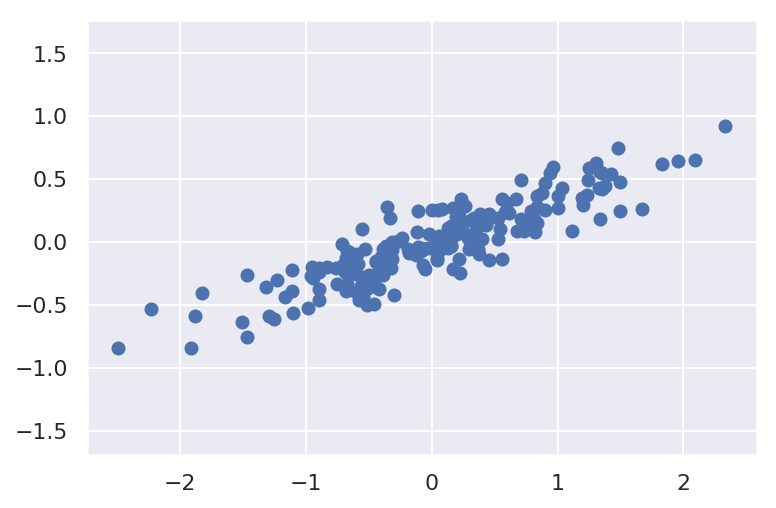

In [2]:
rng = np.random.RandomState(1)
X = np.dot(rng.rand(2, 2), rng.randn(2, 200)).T
plt.scatter(X[:, 0], X[:, 1])
plt.axis('equal');

Al mirar el gráfico se vuelve claro que hay una relación lineal entre las variables $x$ e $y$.
Esto nos recuerda a la clase de regresión lineal, pero la configuración del problema es diferente esta vez: en vez que intentar _predecir_ los valores de $y$ a partir de $x$, el problema no supervisado intenta aprender la _relación_ entre los valores de $x$ e $y$.

En el análisis de componentes principales, esta relación se cuantifica al encontrar una lista de _ejes principales_ en los datos, y utilizar esos ejes para describir los datos. En Scikit-Learn esto se logra con la clase de estimador ``PCA``:

In [3]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

El ajuste entrega, entre otras cosas, dos atributos cuantitativos importantes: las "componentes" y la "explicación de la varianza":

In [4]:
print(pca.components_)

[[-0.94446029 -0.32862557]
 [-0.32862557  0.94446029]]


In [5]:
print(pca.explained_variance_)

[0.7625315 0.0184779]


Vemos que las componentes son dos vectores, y que la explicación de la varianza son dos números.
Para ver qué significan, visualicémoslos como vectores sobre los datos, usando las "componentes" para definir la dirección de cada vector, y la "explicación de la varianza" para definir la raíz cuadrada de cada vector:

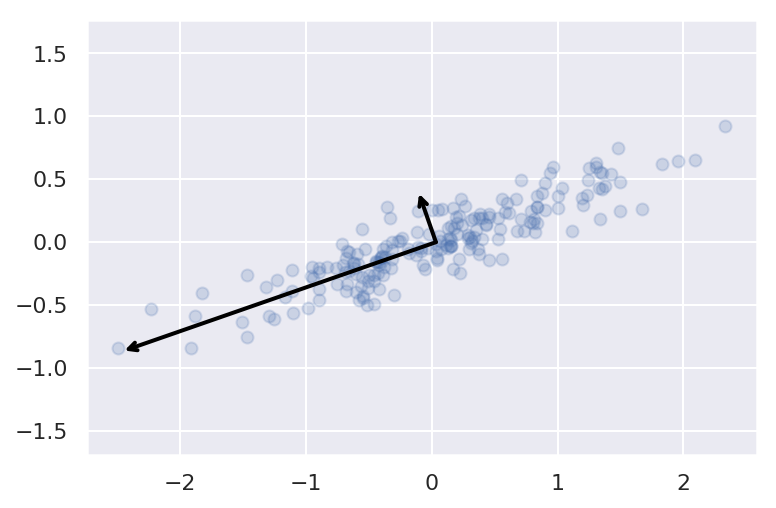

In [6]:
def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',
                    linewidth=2,
                    shrinkA=0, shrinkB=0, color='black')
    ax.annotate('', v1, v0, arrowprops=arrowprops)

# plot data
plt.scatter(X[:, 0], X[:, 1], alpha=0.2)
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 3 * np.sqrt(length)
    draw_vector(pca.mean_, pca.mean_ + v)
plt.axis('equal');

Estos vectores representan los _ejes principales_ de los datos, y el largo de cada vector indica qué tan "importante" es el eje en describir la distribución de los datos. Dicho de una manera más precisa, es una medida de la varianza de los datos cuando son proyectados en ese eje.

Las proyecciones de cada punto en los ejes principales son las llamadas "componentes principales" de los datos.

Si graficamos las componentes principales junto a los datos originales, veremos lo siguiente:

![](figures/05.09-PCA-rotation.png)

Esta transformación desde ejes en los datos a los ejes principales es, en términos matemáticos, una _transformación afín_, lo que quiere decir que está compuesta por una traslación, rotación, y escalamiento uniforme.

Aunque este algoritmo para encontrar componentes principales pueda verse como una curiosidad matemática debido a su simpleza, sucede que tiene vastas aplicaciones en el mundo de machine learning y de exploración de datos.

### PCA como reducción dimensional

Usar PCA para reducir la dimensionalidad de los datos involucra anular una o más de las componentes principales, quedándose con las más grandes. Esto resulta en una proyección dimensional más baja que la original, pero que maximiza la varianza de los datos.

Aquí hay un ejemplo de uso de PCA como reducción dimensional:

In [7]:
pca = PCA(n_components=1)
pca.fit(X)
X_pca = pca.transform(X)
print("dimensiones originales:", X.shape)
print("dimensiones reducidas :", X_pca.shape)

dimensiones originales: (200, 2)
dimensiones reducidas : (200, 1)


Los datos transformados se han reducido a una única dimensión. Para entender el efecto de esta reducción dimensional, podemos realizar una transformación inversa, y graficarla en conjunto con los datos originales:

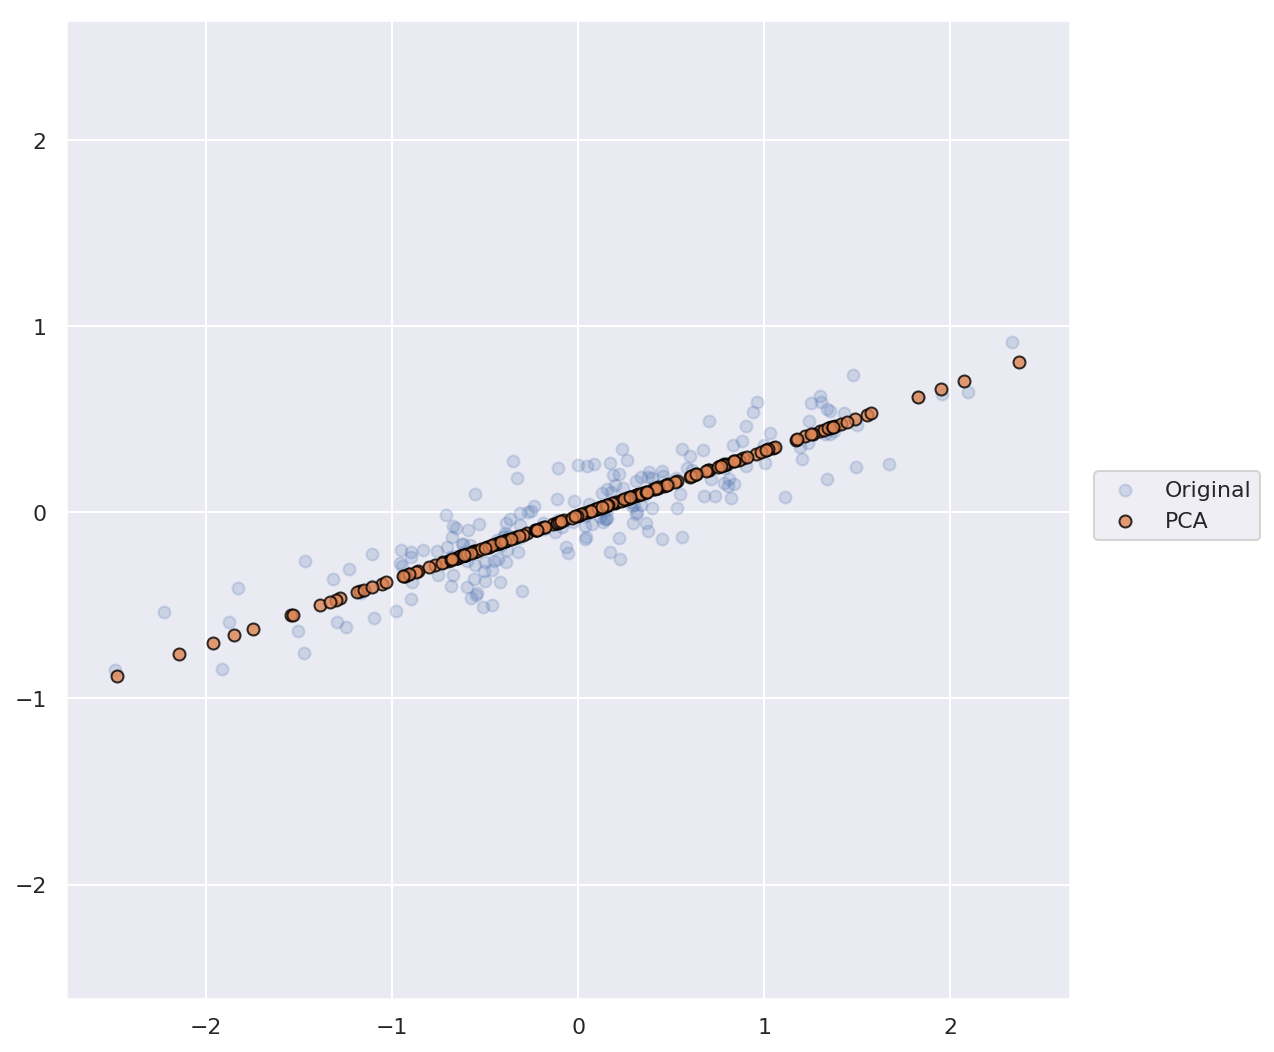

In [8]:
plt.figure(figsize=(9, 9))
X_new = pca.inverse_transform(X_pca)
plt.scatter(X[:, 0], X[:, 1], alpha=0.2, label='Original')
plt.scatter(X_new[:, 0], X_new[:, 1], alpha=0.8, edgecolor='black', label='PCA')
plt.axis('equal')
plt.legend(bbox_to_anchor=(1.20, 0.55));

Los puntos claros son los datos originales, mientras que los oscuros son los proyectados.
Esto aclara lo que hace la reducción dimensional de PCA: la información a lo largo de los ejes principales menos importantes se descarta, dejando solamente la(s) componente(s) de los datos con una mayor varianza.
La fracción de la varianza que se descarta, que es proporcional a la dispersión de los puntos alrededor de la recta que se observa en la figura, es una medida gruesa de cuanta información se ha perdido en la reducción dimensional.

Este dataset de dimensiones reducidas es en algunos sentidos lo "suficientemente bueno" para codificar las relaciones más importantes entre los datos: a pesar de redudir la dimensión de los datos a la mitad, las relaciones generales entre las observaciones se mantienen.

### PCA para visualización: Dígitos escritos a mano


La utilidad de reducir dimensiones puede no ser aparente al trabajar en dos dimensiones, pero se vuelve mucho más clara cuando se observan datos con muchas dimensiones.
Para explorar esto, veamos los datos de dígitos que ya hemos revisado antes.

Carguemos los datos:

In [9]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

Recordemos que los datos consisten en 1,797 imágenes de 8×8 píxeles, por lo que tienen 64 dimensiones.

Para entender cómo cada imagen se relaciona con otra, podemos usar PCA para proyectarlas en un respacio más manejable, por ejemplo, de dos dimensiones:

In [10]:
pca = PCA(2)  # proyecta de 64 a 2 dimensiones
projected = pca.fit_transform(digits.data)
print(digits.data.shape)
print(projected.shape)

(1797, 64)
(1797, 2)


Ahora podemos graficar las dos primeras componentes principales de cada punto:

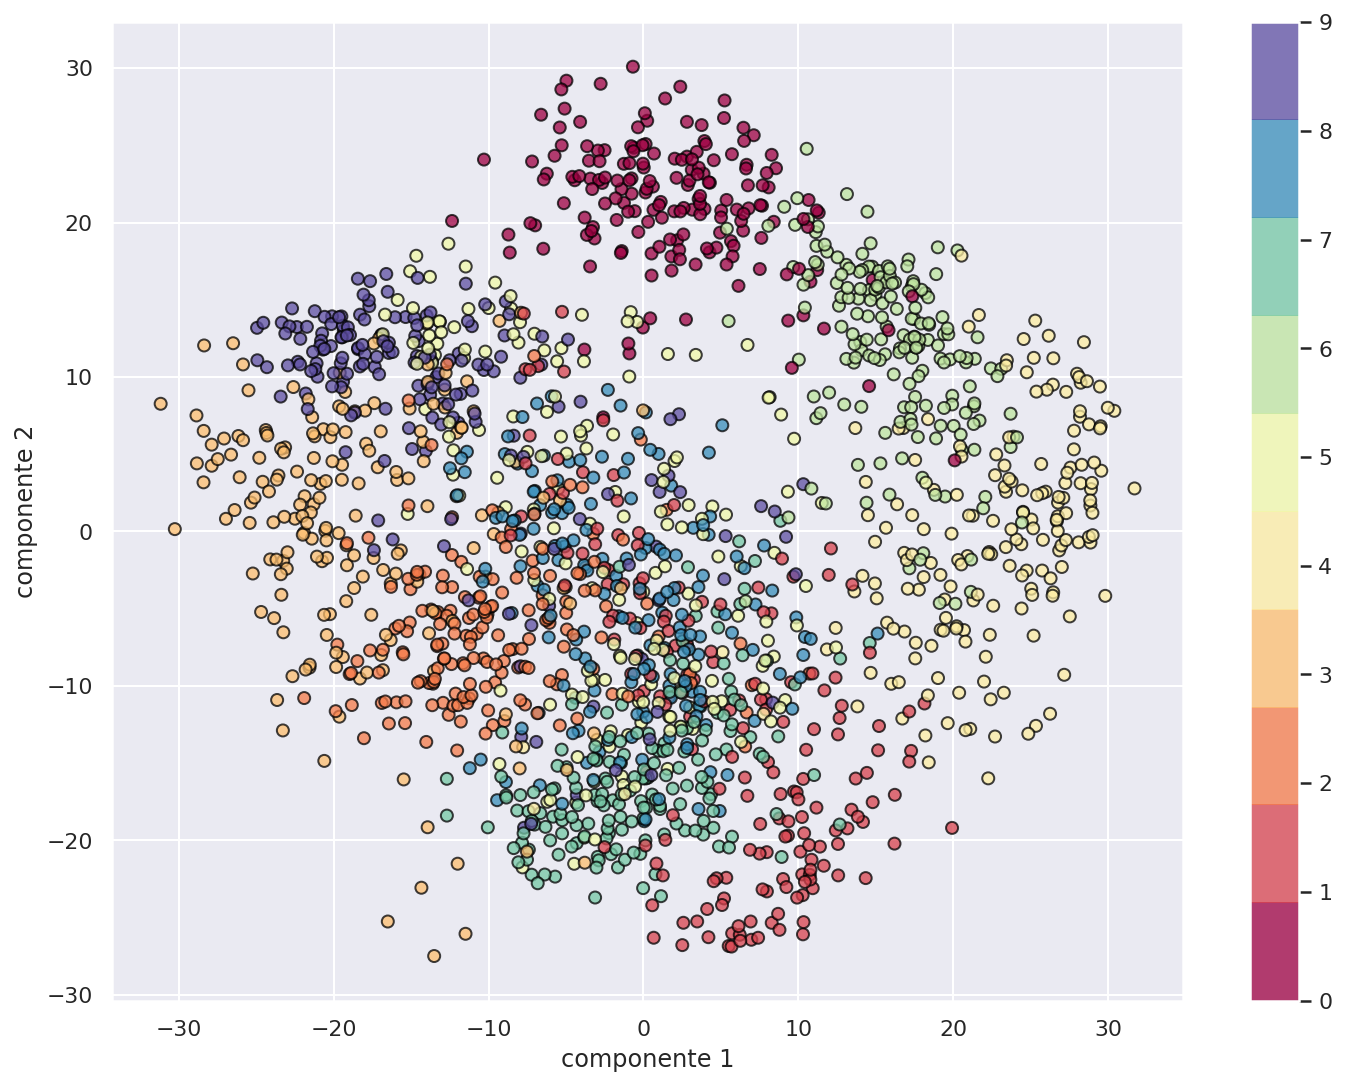

In [11]:
plt.figure(figsize=(12, 9))
plt.scatter(projected[:, 0], projected[:, 1],
            c=digits.target, edgecolor='black', alpha=0.75,
            cmap=plt.cm.get_cmap('Spectral', 10))
plt.xlabel('componente 1')
plt.ylabel('componente 2')
plt.colorbar();

Recordemos lo que significan estas componentes: el dataset completo tiene puntos en 64 dimensiones, y estos puntos del gráfico son la proyección del dataset a través de las direcciones que presentan la mayor varianza.
Esencialmente, hemos encontrado las operaciones de escalamiento y rotación en un espacio de 64 dimensiones que nos permiten ver la organización de los dígitos en solamente dos. Y lo hemos hecho en una manera no supervisada, es decir, sin referencias a las etiquetas de cada dígito.

### ¿Qué significan las componentes?

Podríamos ir un poco más lejos y preguntarnos cuál es la interpretación de las dimensiones reducidas.
Esto se puede entender en términos de una combinación de vectores basales.
Por ejemplo, cada imagen en el set de entrenamiento está definida como una colección de 64 valores, uno por píxel, que llamaremos vector $x$:

$$
x = [x_1, x_2, x_3 \cdots x_{64}]
$$

Una manera de pensar sobre esto es en términos de píxeles base.
Es decir, para construir la imagen, multiplicaremos cada elemento del vector por el píxel que describe, y después juntaremos todos los resultados para armar la imagen:

$$
{\rm image}(x) = x_1 \cdot{\rm (pixel~1)} + x_2 \cdot{\rm (pixel~2)} + x_3 \cdot{\rm (pixel~3)} \cdots x_{64} \cdot{\rm (pixel~64)}
$$

Una manera de reducir la dimensión de estos datos es anular una gran cantidad de los vectores base, de modo de quedarse con unos pocos.
Por ejemplo, si solamente usáramos los primeros ocho píxeles, efectivaente tendríamos una proyección en ocho dimensiones de los datos, pero no sería representativa de la imagen completa: habríamos tirado por la borda prácticamente 90% de los píxeles.

![](figures/05.09-digits-pixel-components.png)

La primera fila de paneles muestra los píxeles individuales, y la fila inferior muestra la distribución acumulada de esos píxeles en la construcción de la imagen.
Usando solamente esas ocho bases, podemos reconstruir una pequeña porción de la imagen original.
Si continuamos haciendo esto para cada uno de los píxeles, recuperaríamos la imagen completa.

Pero una base en función de los píxeles no es la única opción. También podemos usar otras funciones base, donde cada una contenga alguna contribución predefinida para cada píxel, y escribir algo como:

$$
image(x) = {\rm mean} + x_1 \cdot{\rm (basis~1)} + x_2 \cdot{\rm (basis~2)} + x_3 \cdot{\rm (basis~3)} \cdots
$$

PCA se puede pensar como el proceso de elegir funciones base óptimas, tal que sumar las primeras sean suficientes para reconstruir la parte más relevante de cada imagen en el dataset.
Las componentes principales son simplemente los coeficientes que multiplican a cada uno de los elementos en la serie de funciones base. 
Esta imagen muestra el esquema de filas anterior, pero utilizando las primeras ocho componentes principales (o funciones base PCA):

![](figures/05.09-digits-pca-components.png)

Al contrario de las bases de píxeles, las bases PCA permiten recuperar las características más salientes de la imagen original solamente con un promedio más ocho componentes.
La cantidad de cada píxel en cada componente es el corolario de la orientación del vector en nuestro ejemplo bidimensional.
En este sentido, PCA provee una representación reducida en dimensiones de los datos al descubrir las funciones base que son más eficientes que las funciones ingenuas basadas en píxeles.

### ¿Cómo elegir el número de componentes?

Una parte vital en el uso de PCA en la práctica es la habilidad de estimar cuántas componentes son necesarias para describir los datos.
Esto se puede determinar mirando la distribución acumulada del _radio de varianza explicada_ como una función del número de componentes:

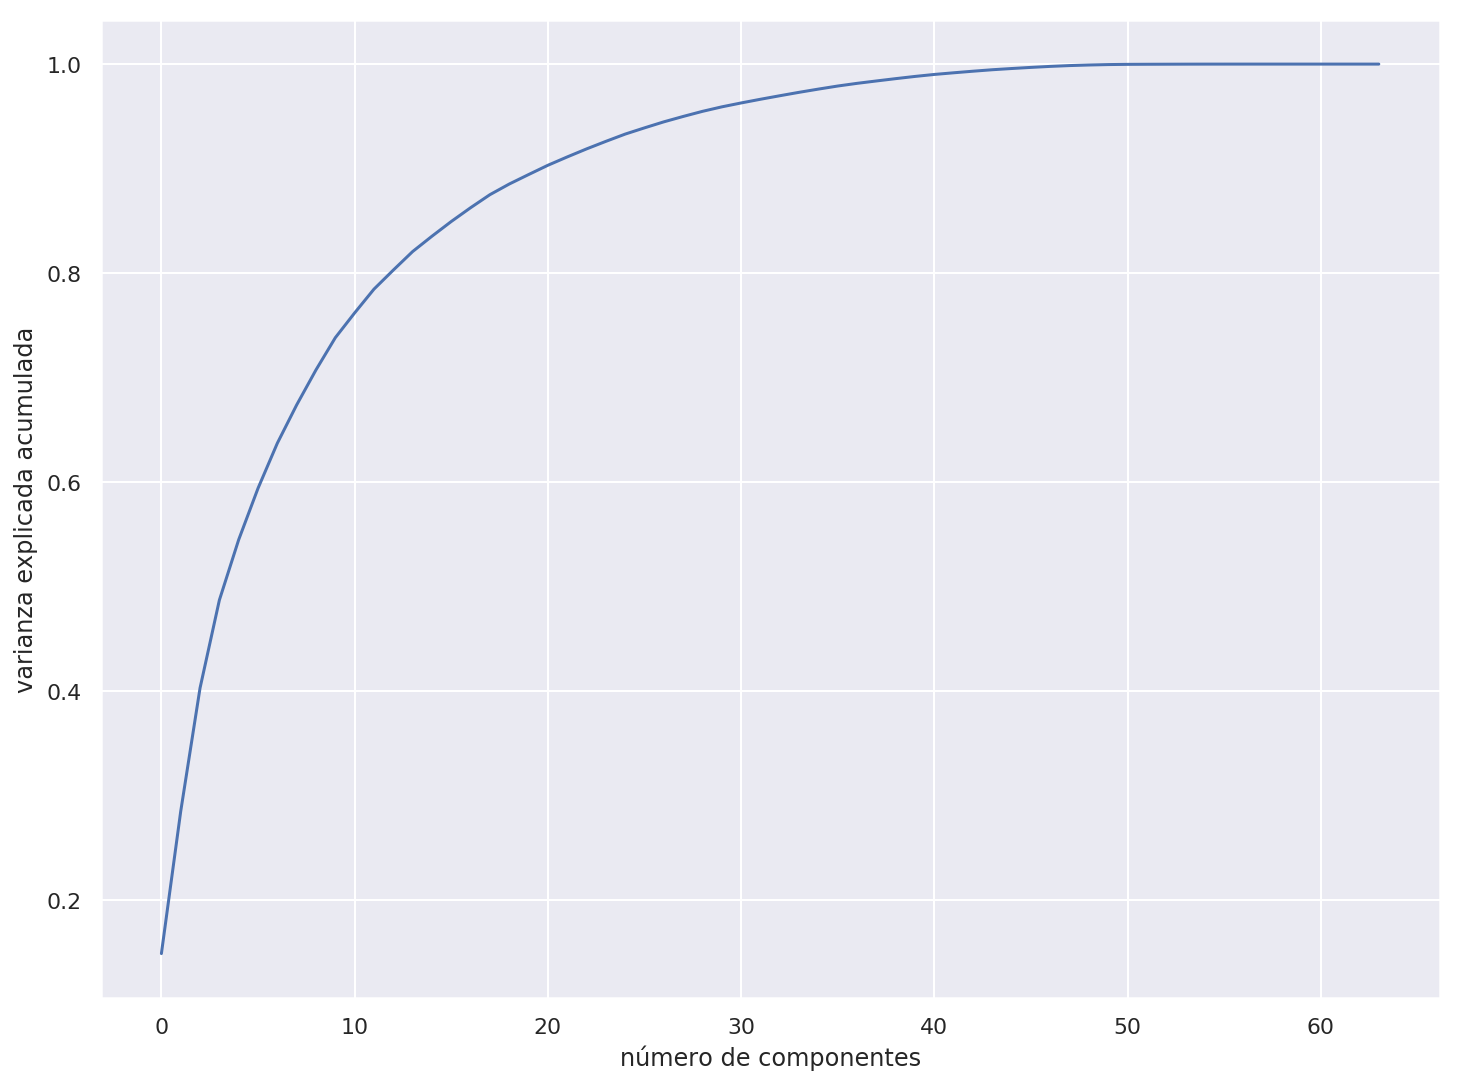

In [12]:
plt.figure(figsize=(12, 9))
pca = PCA().fit(digits.data)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('número de componentes')
plt.ylabel('varianza explicada acumulada');

Esta curva cuantifica cuánto del total de la varianza en el espacio original de 64 dimensiones está contenida dentro de las primeras $N$ componentes.
Por ejemplo, en el gráfico vemos que las primeras diez componentes contienen aproximadamente 75% de la varianza, mientras que necesitas alrededor de 50 componentes para describir casi el total de ella.

Aquí vemos que nuestra proyección bidimensional pierde mucha información (en función de la varianza explicada), de modo que necesitaríamos cerca de 20 componentes para mantener el 90% de la varianza. Inspeccionar este tipo de gráfico te puede ayudar a entender el nivel de redundancia presente en múltiples observaciones.

## PCA como Filtro de Ruido

PCA también se puede utilizar como un filtro para datos ruidosos.
La idea es la siguiente: cualquier componente con una varianza mucho más larga que el efecto del ruido debería no ser afectada por el ruido. De modo que si reconstruyes los datos utilizando las componentes principales más grandes, preferentemente mantendrías la señal de los datos mientras descartarías el ruido.

Veamos cómo funciona esto con los dígitos.
Así se ven los datos sin ruido, tal como vienen en el dataset:

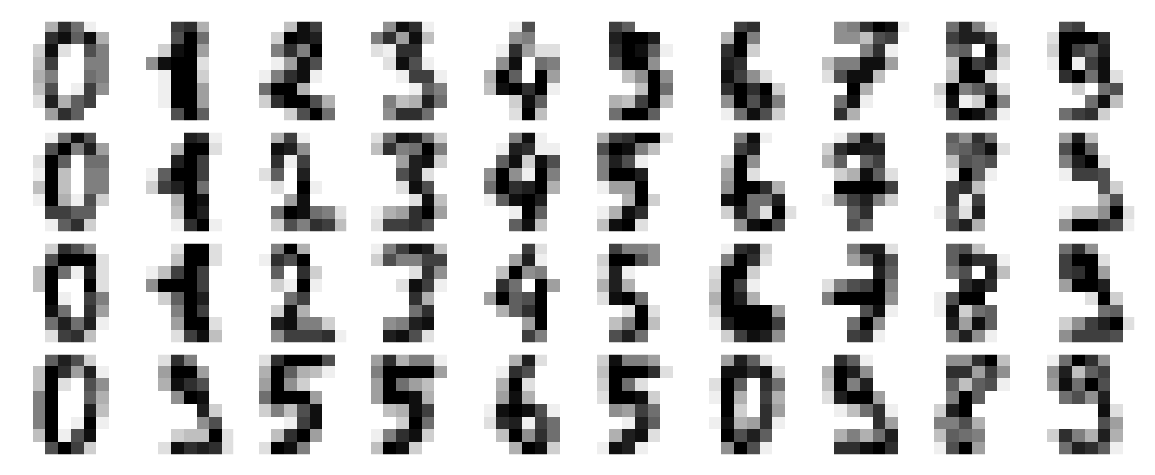

In [13]:
def plot_digits(data):
    fig, axes = plt.subplots(4, 10, figsize=(10, 4),
                             subplot_kw={'xticks':[], 'yticks':[]},
                             gridspec_kw=dict(hspace=0.1, wspace=0.1))
    for i, ax in enumerate(axes.flat):
        ax.imshow(data[i].reshape(8, 8),
                  cmap='binary', interpolation='nearest',
                  clim=(0, 16))
plot_digits(digits.data)

Agreguemos ruido y grafiquemos de nuevo:

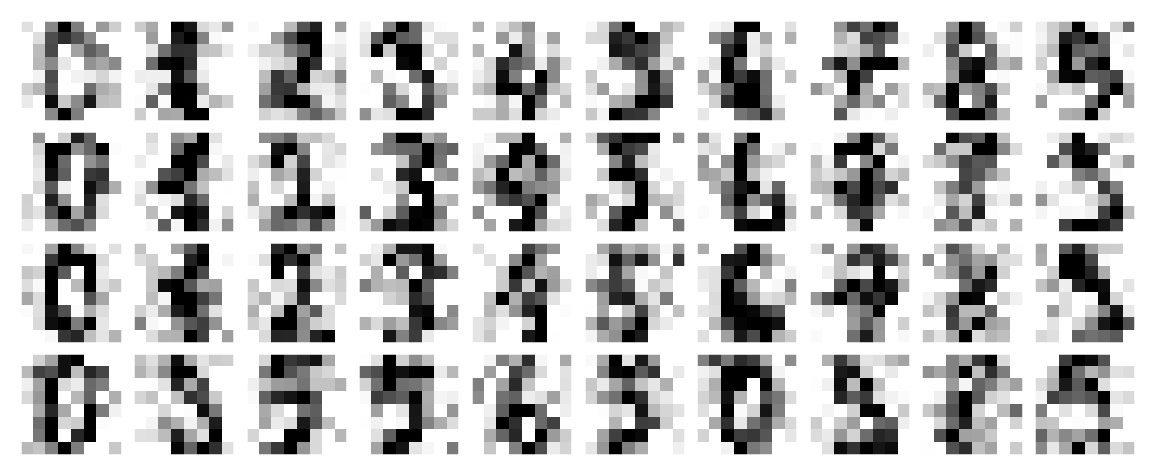

In [14]:
np.random.seed(42)
noisy = np.random.normal(digits.data, 4)
plot_digits(noisy)

Se nota visualmente que las imágenes tienen ruido, y que contienen píxeles sin significado.
Ajustemos una PCA en los datos con ruido, pidiéndole que mantenga un 50% de la varianza:

In [15]:
pca = PCA(0.50).fit(noisy)
pca.n_components_

12

Aquí el 50% de la varianza se determina por 12 componentes principales.
Ahora computaremos las componentes, y después usaremos la inversa de la transformación para reconstruir los dígitos filtrados:

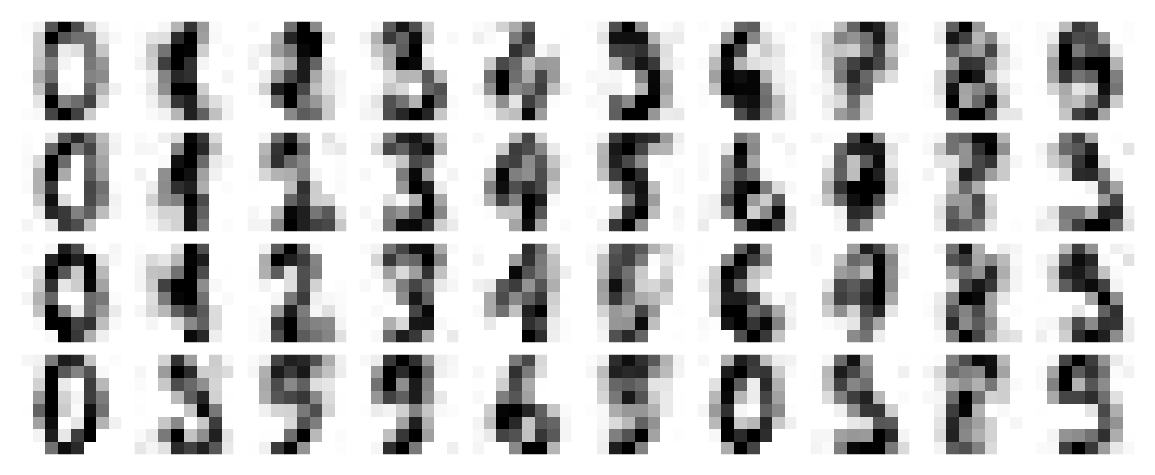

In [16]:
components = pca.transform(noisy)
filtered = pca.inverse_transform(components)
plot_digits(filtered)

Esta propiedad de preservar la señal y filtrar el ruido hace que PCA sea una técnica útil de selección de características, por ejemplo, en vez de entrenar un clasificador en datos altamente dimensonales, puedes entrenarlos en una representación reducida dimensionalmente, que automáticamente filtrará el ruido aleatorio en los datos de entrada.

## Ejemplo: Eigenfaces

Para probar lo anterior haremos uso de un dataset de fotos de caras conocido como _Labeles Faces in the Wild_, disponibles en Scikit-Learn:

In [17]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)
print(faces.target_names)
print(faces.images.shape)

/home/egraells/.virtualenvs/jupyter/lib/python3.5/site-packages/sklearn/datasets/lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
/home/egraells/.virtualenvs/jupyter/lib/python3.5/site-packages/sklearn/datasets/lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
/home/egraells/.virtualenvs/jupyter/lib/python3.5/site-packages/sklearn/datasets/lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
/home/egraells/.virtualenvs/jupyter/lib/python3.5/site-packages/sklearn/datasets/lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
(1348, 62, 47)


Al igual que los dígitos, son imágenes. Veamos los ejes principales que caracterizan este dataset.
Porque el dataset es grande, usaremos el estimador ``RandomizedPCA``, que contiene un método aleatorio para aproximar las primeras $N$ componentes principales de manera más rápida que el estimador ``PCA`` estándar, y por lo tanto es muy útil para datos altamente dimensionales (aquí, la dimensionalidad es aproximadamente 3.000).
Veamos las primeras 150 componentes:

In [18]:
from sklearn.decomposition import RandomizedPCA
pca = RandomizedPCA(150)
pca.fit(faces.data)

/home/egraells/.virtualenvs/jupyter/lib/python3.5/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


RandomizedPCA(copy=True, iterated_power=2, n_components=150,
       random_state=None, whiten=False)

En este caso, puede ser interesante visualizar las imágenes asociadas con las primeras componentes principales (estas componentes son llamadas técnicamente como _eigenvectors_, así que este tipo de imágenes se suele llamar _eigenfaces_).
Como puedes ver en la visualización, son tan extrañas como el nombre que reciben:

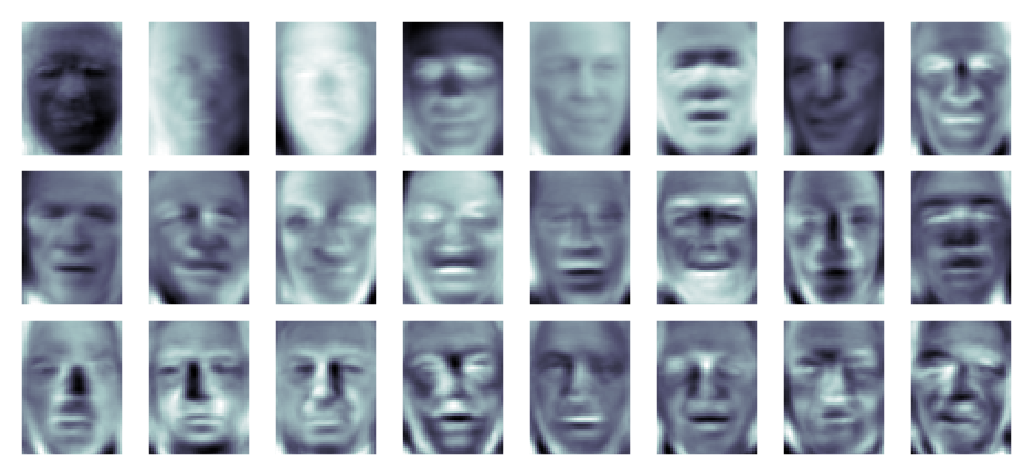

In [19]:
fig, axes = plt.subplots(3, 8, figsize=(9, 4),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axes.flat):
    ax.imshow(pca.components_[i].reshape(62, 47), cmap='bone')

Los resultados son muy interesantes, y nos permiten entender cómo varían las imágenes: por ejemplo, las primeras _eigenfaces_ (arriba izquierda) parecen estar asociadas con el ángulo de la luz en la cara, y los vectores que aparecen después parecen representar otras características, como ojos, narices y labios.
Veamos la varianza acumulada de estas componentes para ver cuánta información mantiene la proyección:

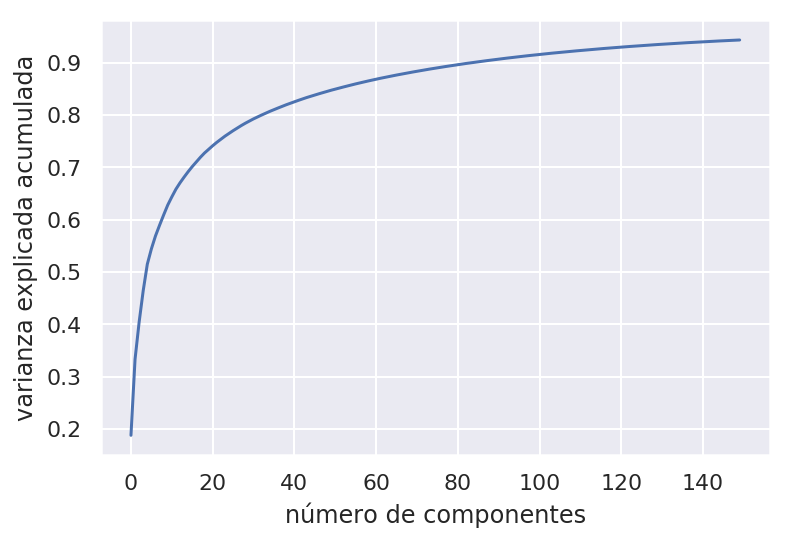

In [20]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('número de componentes')
plt.ylabel('varianza explicada acumulada');

Vemos que las 150 componentes cuentan por poco más que el 90% de la varianza.
Esto nos llevaría a creer que, al usarlas, recuperaríamos buena parte de las características esenciales de los datos.
Para concretizar esa idea, podemos comparar las imágenes originales con las reconstruidas a partir de las 150 componentes:

In [21]:
# Computar las componentes y las caras proyectadas
pca = RandomizedPCA(150).fit(faces.data)
components = pca.transform(faces.data)
projected = pca.inverse_transform(components)

/home/egraells/.virtualenvs/jupyter/lib/python3.5/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


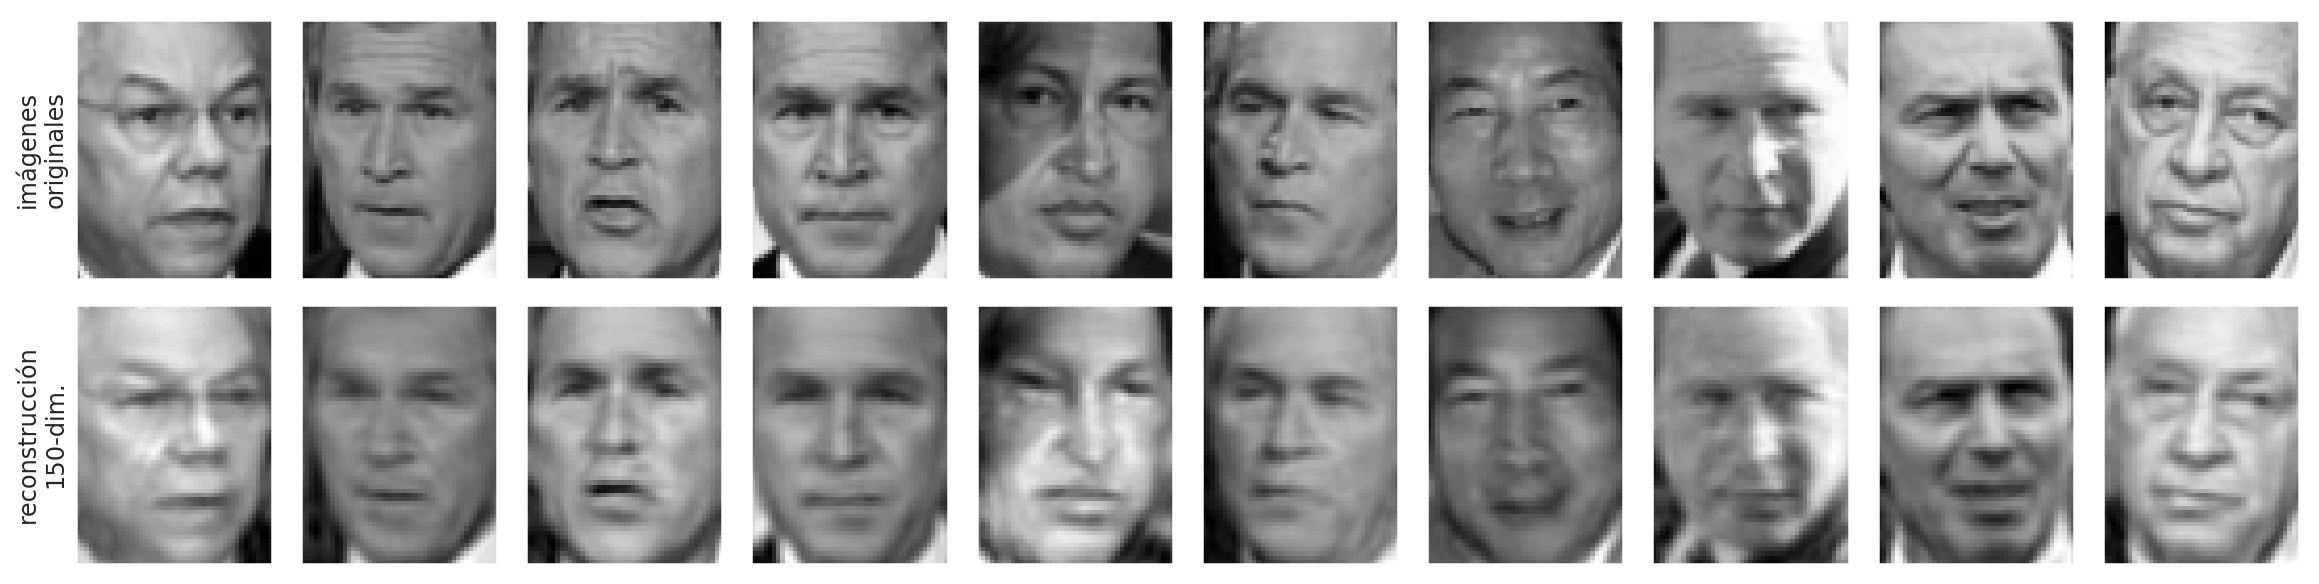

In [22]:
fig, ax = plt.subplots(2, 10, figsize=(20, 5),
                       subplot_kw={'xticks':[], 'yticks':[]},
                       gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i in range(10):
    ax[0, i].imshow(faces.data[i].reshape(62, 47), cmap='binary_r')
    ax[1, i].imshow(projected[i].reshape(62, 47), cmap='binary_r')
    
ax[0, 0].set_ylabel('imágenes\noriginales')
ax[1, 0].set_ylabel('reconstrucción\n150-dim.');

La fila superior muestra las imágenes originales, mientras que la inferior la reconstrucción a partir de 150 dimensiones.
Esta visualización muestra cómo PCA, incluso reduciendo los datos por un factor de 20, permite reconstruir las imágenes de tal modo que, al ojímetro, podemos reconocer a las personas en la imagen.
Esto significa que nuestro algoritmo de clasificación se puede entrenar en 150 dimensiones en vez de 3.000, lo que, dependiendo de la técnica que utilicemos, puede llevarnos a una clasificación más eficiente.

## Resumen

En esta sección hemos discutido el uso del análisis de componentes principales para reducción dimensional, para visualizar datos altamente dimensiones, para filtrar ruido, y para selección de características.
Dada la versatilidad e interpretabilidad de PCA, la técnica ha demostrado ser efectiva en un amplio rango de contextos y disciplinas.

Dado un dataset altamente dimensional, una buena manera de comenzar el análisis es utilizar PCA para visualizar las relaciones entre los puntos, de modo de entender qué es lo que produce la mayor varianza en los datos, y también comprender la dimensionalidad intrínseca que poseen.
Ciertamente PCA no es útil para cada tipo de dataset altamente dimensional, pero ofrece una manera directa y eficiente de ganar conocimiento.

Su mayor debilidad es que suele sesgar sus resultados por outliers en los datos.
Por esta razón, se han propuesto variaciones de PCA, algunas de las cuales descartan puntos de manera iterativa que son malamente descritos por las componentes iniciales. Scikit-Learn incluye algunas variantes interesantes, incluyendo ``RandomizedPCA`` y ``SparsePCA``, ambas en el módulo ``sklearn.decomposition``.
``RandomizedPCA``, que vimos anteriormente, utiliza un método no determinístico para aproximar las primeras componentes principales en datos extremadamente grandes en términos de dimensiones, mientras que ``SparsePCA`` introduce un término de regularización que permite forzar la dispersión de las componentes.

## Créditos

![](figures/PDSH-cover.png)

Este notebook contiene un extracto del libro [Python Data Science Handbook](http://shop.oreilly.com/product/0636920034919.do) por Jake VanderPlas; el contenido también está disponible en [GitHub](https://github.com/jakevdp/PythonDataScienceHandbook).

El texto se distribuye bajo una licencia [CC-BY-NC-ND](https://creativecommons.org/licenses/by-nc-nd/3.0/us/legalcode), y el código se distribuye bajo la licencia [MIT](https://opensource.org/licenses/MIT). Si te parece que este contenido es útil, por favor considera apoyar el trabajo [comprando el libro](http://shop.oreilly.com/product/0636920034919.do).

Traducción al castellano por [Eduardo Graells-Garrido](http://datagramas.cl), liberada bajo las mismas condiciones.